# FPI Data Processing

### Loading in the Fabry-Perot data

In [2]:
import sys
import os
import pandas as pd

%load_ext autoreload
%autoreload 2

# Get the absolute path of the project root (fpi_ml)
project_root = "/Users/elliotdable/Documents/PhD/research/fpi_ml"
sys.path.append(project_root)

# Now try importing using 'src.'
from src.GNN.load_data import indra_fpi_loader

In [2]:
base_directory = "/Users/elliotdable/Documents/PhD/research/fpi_ml/data/fpi_data/indra/raw_fpi_data/"
fpi_2013_2024 = indra_fpi_loader(base_directory)

Processing file 1 of 4474
Processing file 2 of 4474
Processing file 3 of 4474
Processing file 4 of 4474
Processing file 5 of 4474
Processing file 6 of 4474
Processing file 7 of 4474
Processing file 8 of 4474
Processing file 9 of 4474
Processing file 10 of 4474
Processing file 11 of 4474
Processing file 12 of 4474
Processing file 13 of 4474
Processing file 14 of 4474
Processing file 15 of 4474
Processing file 16 of 4474
Processing file 17 of 4474
Processing file 18 of 4474
Processing file 19 of 4474
Processing file 20 of 4474
Processing file 21 of 4474
Processing file 22 of 4474
Processing file 23 of 4474
Processing file 24 of 4474
Processing file 25 of 4474
Processing file 26 of 4474
Processing file 27 of 4474
Processing file 28 of 4474
Processing file 29 of 4474
Processing file 30 of 4474
Processing file 31 of 4474
Processing file 32 of 4474
Processing file 33 of 4474
Processing file 34 of 4474
Processing file 35 of 4474
Processing file 36 of 4474
Processing file 37 of 4474
Processing

In [3]:
fpi_2013_2024 = pd.read_csv('/Users/elliotdable/Documents/PhD/research/fpi_ml/data/fpi_data/indra/processed_fpi_data/scandinavia_2013_2024.csv')
geomag_df = pd.read_csv('/Users/elliotdable/Documents/PhD/research/fpi_ml/data/geomag_data/solar_geomag_dst_data.csv')

import pandas as pd

# Ensure both datetime columns are real datetime dtype
fpi_2013_2024['datetime'] = pd.to_datetime(fpi_2013_2024['datetime'])
geomag_df['datetime'] = pd.to_datetime(geomag_df['datetime'])

# Sort before merge_asof (required)
fpi_2013_2024 = fpi_2013_2024.sort_values('datetime')
geomag_df = geomag_df.sort_values('datetime')

# Merge AP30 onto FPI data by nearest datetime
fpi_2013_2024 = pd.merge_asof(
    fpi_2013_2024,
    geomag_df[['datetime', 'ap30']],   # only need datetime + ap30
    on='datetime',
    direction='nearest'                # choose closest match
)

fpi_2013_2024 = fpi_2013_2024.rename(columns={'ap30': 'ap'})

In [4]:
fpi_2013_2024.sample(5)

,datetime,site,mirror,look_direction,azimuth_angle,altitude,fpi_latitude,fpi_longitude,observation_latitude,observation_longitude,...,intensity_error,wind_speed,wind_speed_error,wind_direction,temperature,temperature_error,chi_squared,snr,ap,ap
1523016,2024-02-13 02:22:59,kiruna_red,2,E,90.0,240.0,67.87,21.03,67.870000,29.123902,...,3.89,102.62,7.78,90.0,1407.48,34.88,0.12,7923.0,9,9
2034578,2025-02-08 04:02:07,kiruna_red,12,Kir B,157.0,240.0,67.87,21.03,65.063336,24.192540,...,4.93,164.27,10.58,157.0,1338.37,45.38,0.07,4166.0,32,32
1224684,2023-02-04 02:47:54,sodankyla_red,1,N,8.0,240.0,67.37,26.63,70.389376,27.732830,...,92.17,183.38,5.22,188.0,1700.15,32.13,0.22,18078.0,18,18
156150,2014-12-24 21:55:29,kiruna_red,12,Kir B,157.0,240.0,67.87,21.03,65.063336,24.192540,...,4.35,219.55,1.62,157.0,1606.17,7.60,0.17,211463.0,9,9
288049,2016-01-09 06:42:49,kiruna_red,11,Kir A,44.0,240.0,67.87,21.03,70.063302,26.652497,...,1.93,95.53,5.38,224.0,1431.81,22.73,0.15,17677.0,5,5


In [ ]:
#fpi_2013_2024.to_csv('/Users/elliotdable/Documents/PhD/research/fpi_ml/data/fpi_data/indra/processed_fpi_data/scandinavia_2013_2024.csv', index=False)

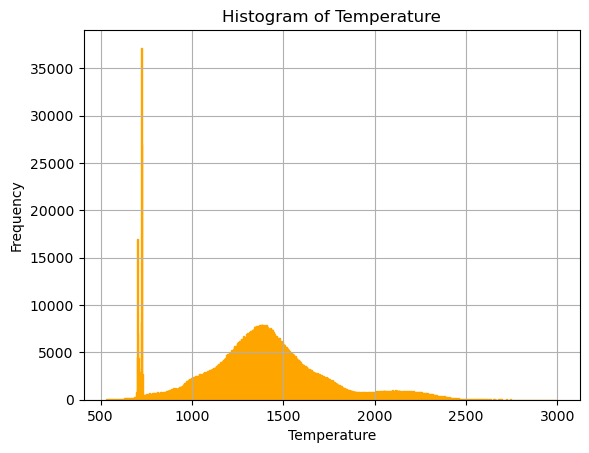

In [5]:
import matplotlib.pyplot as plt

fpi_df = fpi_2013_2024[fpi_2013_2024['temperature'] > 530]
# Histogram of the 'temperature' column
fpi_df['temperature'].hist(bins=1000, edgecolor='orange')

plt.xlabel('Temperature')
plt.ylabel('Frequency')
plt.title('Histogram of Temperature')
plt.show()

In [6]:
import numpy as np
import pandas as pd

# work on temps >= 530 K
x = fpi_df.loc[fpi_df['temperature'] >= 530, 'temperature'].to_numpy()

# --- histogram with fine bins (1 K; adjust if your resolution differs)
bin_width = 1.0
bins = np.arange(np.nanmin(x), np.nanmax(x) + bin_width, bin_width)
counts, edges = np.histogram(x, bins=bins)

# --- local baseline via rolling median (robust to tails)
w = 51  # odd window ~50 K neighborhood
half = w // 2
med = np.array([
    np.median(counts[max(0, i-half):min(len(counts), i+half+1)])
    for i in range(len(counts))
])

# --- flag spike bins: high absolute AND far above local baseline
abs_floor = 800            # absolute floor (tune)
rel_factor = 6.0           # how many times above local median (tune)
spike_idx = np.where((counts > abs_floor) & (counts > rel_factor * (med + 1)))[0]

# --- merge contiguous spike bins into ranges (expand by 1 on each side for safety)
bad_ranges = []
if len(spike_idx):
    start = spike_idx[0]
    prev = spike_idx[0]
    for i in spike_idx[1:]:
        if i == prev + 1:
            prev = i
        else:
            lo = edges[max(0, start-1)]
            hi = edges[min(len(edges)-1, prev+2)]
            bad_ranges.append((lo, hi))
            start = prev = i
    lo = edges[max(0, start-1)]
    hi = edges[min(len(edges)-1, prev+2)]
    bad_ranges.append((lo, hi))

print("Spike ranges to remove:", bad_ranges)

# --- filter out all temperatures in those ranges
clean_df = fpi_df.copy()
for lo, hi in bad_ranges:
    clean_df = clean_df[~((clean_df['temperature'] >= lo) & (clean_df['temperature'] < hi))]


Spike ranges to remove: [(699.02, 703.02), (721.02, 728.02)]


In [7]:
clean_df = fpi_df[~((fpi_df['temperature'] >= 695) & (fpi_df['temperature'] <= 730))]

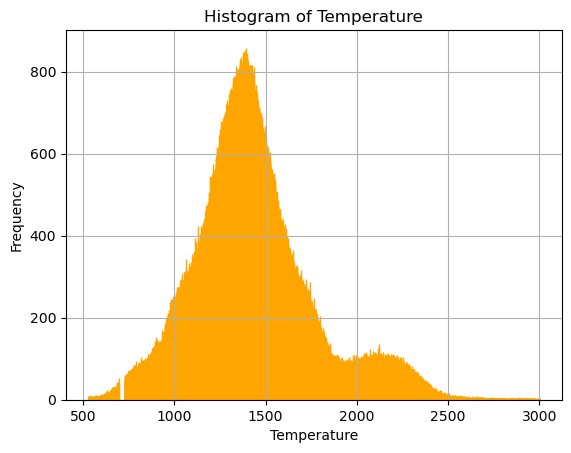

In [8]:
import matplotlib.pyplot as plt

clean_df['temperature'].hist(bins=10000, edgecolor='orange')

plt.xlabel('Temperature')
plt.ylabel('Frequency')
plt.title('Histogram of Temperature')
plt.show()

In [35]:
#clean_df.to_csv('/Users/elliotdable/Documents/PhD/research/fpi_ml/data/fpi_data/indra/processed_fpi_data/scandinavia_2013_2024_cleaned_temps.csv', index=False)

### By Hour

/var/folders/pf/x6mn9jt96z14ybg9rxsvmb100000gn/T/ipykernel_20339/2280389808.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_df['datetime'] = pd.to_datetime(clean_df['datetime'])
/var/folders/pf/x6mn9jt96z14ybg9rxsvmb100000gn/T/ipykernel_20339/2280389808.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_df['hour'] = clean_df['datetime'].dt.hour


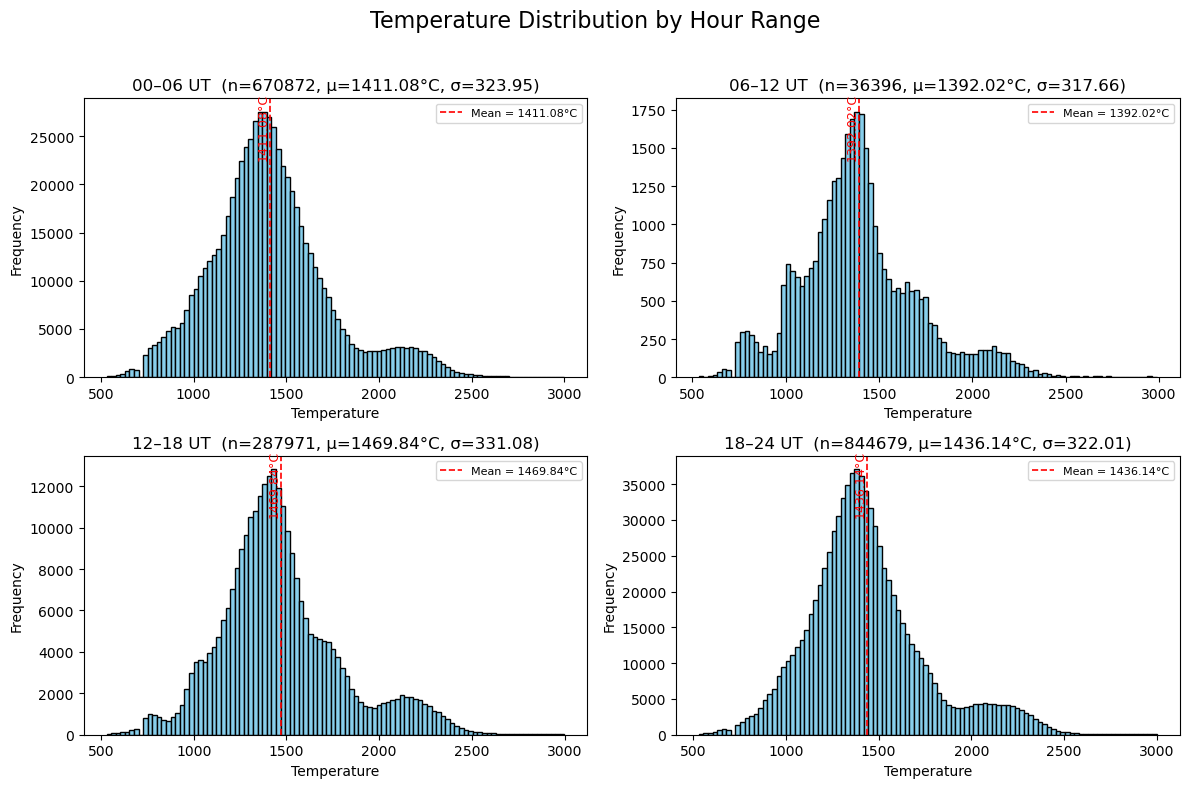

In [9]:
import matplotlib.pyplot as plt
import pandas as pd

# Ensure datetime column is in datetime format
clean_df['datetime'] = pd.to_datetime(clean_df['datetime'])

# Extract hour from datetime
clean_df['hour'] = clean_df['datetime'].dt.hour

# Define the four time ranges
time_ranges = [(0, 6), (6, 12), (12, 18), (18, 24)]
labels = ['00–06 UT', '06–12 UT', '12–18 UT', '18–24 UT']

# Set up subplots (2x2 grid)
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
axes = axes.flatten()
fig.suptitle('Temperature Distribution by Hour Range', fontsize=16)

# Loop through each range and plot histogram
for i, (start, end) in enumerate(time_ranges):
    subset = clean_df[
        (clean_df['hour'] >= start) &
        (clean_df['hour'] < end)
    ]
    
    n = len(subset)
    mean_temp = subset['temperature'].mean()
    std_temp = subset['temperature'].std()
    
    # Plot histogram
    axes[i].hist(subset['temperature'], bins=100, color='skyblue', edgecolor='black')
    axes[i].set_title(f'{labels[i]}  (n={n}, μ={mean_temp:.2f}°C, σ={std_temp:.2f})')
    axes[i].set_xlabel('Temperature')
    axes[i].set_ylabel('Frequency')
    
    # Mean line
    axes[i].axvline(mean_temp, color='red', linestyle='dashed', linewidth=1.2, label=f'Mean = {mean_temp:.2f}°C')
    
    # Annotate mean
    axes[i].text(mean_temp, axes[i].get_ylim()[1]*0.9, f'{mean_temp:.2f}°C',
                 rotation=90, color='red', ha='right', va='center', fontsize=9)
    
    # Optional: legend for clarity
    axes[i].legend(fontsize=8)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

### By Seasons

/var/folders/pf/x6mn9jt96z14ybg9rxsvmb100000gn/T/ipykernel_20339/239427796.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_df['month'] = clean_df['datetime'].dt.month
/var/folders/pf/x6mn9jt96z14ybg9rxsvmb100000gn/T/ipykernel_20339/239427796.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_df['season'] = clean_df['month'].apply(get_season)


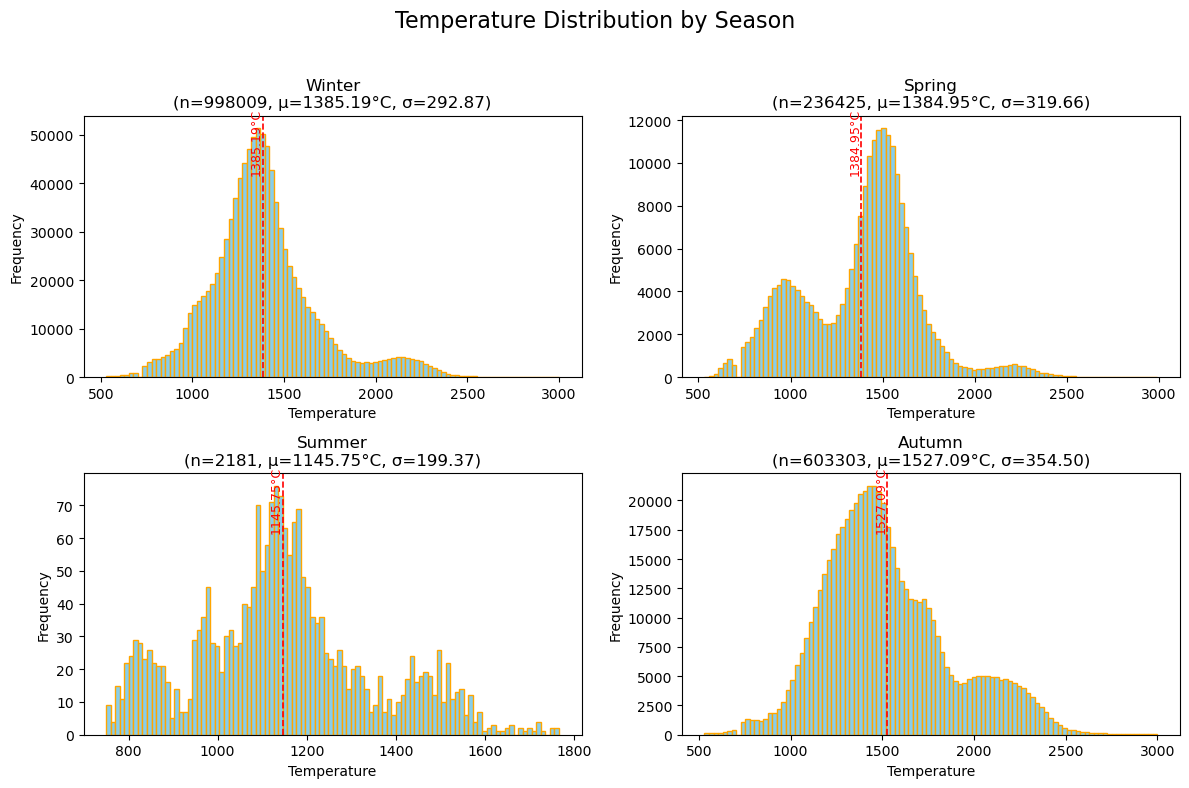

In [10]:
# Extract month and define seasons
clean_df['month'] = clean_df['datetime'].dt.month

def get_season(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    else:
        return 'Autumn'

clean_df['season'] = clean_df['month'].apply(get_season)

# Seasons order
seasons = ['Winter', 'Spring', 'Summer', 'Autumn']

# Plot histograms by season
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
axes = axes.flatten()
fig.suptitle('Temperature Distribution by Season', fontsize=16)

for i, season in enumerate(seasons):
    subset = clean_df[clean_df['season'] == season]
    
    n = len(subset)
    mean_temp = subset['temperature'].mean()
    std_temp = subset['temperature'].std()
    
    axes[i].hist(subset['temperature'], bins=100, color='skyblue', edgecolor='orange')
    
    axes[i].axvline(mean_temp, color='red', linestyle='dashed', linewidth=1.2)
    axes[i].text(mean_temp, axes[i].get_ylim()[1]*0.9, f'{mean_temp:.2f}°C',
                 rotation=90, color='red', ha='right', va='center', fontsize=9)
    
    axes[i].set_title(f'{season}\n(n={n}, μ={mean_temp:.2f}°C, σ={std_temp:.2f})')
    axes[i].set_xlabel('Temperature')
    axes[i].set_ylabel('Frequency')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()
